In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mplhep as hep
#hep.set_style('CMS')
#hep.style.use('CMS')


In [3]:
file = uproot.open('/vols/cms/emc21/FCC/MadGraph_files/distributions/h2h2lPlMvv_l_e_mu/BP1/h2h2lPlMvv_l_e_mu_BP1/Events/run_01/unweighted_events.root')
tree = file['LHEF']
tree = tree['Particle']
print(tree.keys())
data = tree.arrays(['Particle.PID', 'Particle.Px','Particle.Py', 'Particle.Pz', 'Particle.PT', 'Particle.E', 'Particle.Eta'], library='pd')
data

['Particle.fUniqueID', 'Particle.fBits', 'Particle.PID', 'Particle.Status', 'Particle.Mother1', 'Particle.Mother2', 'Particle.ColorLine1', 'Particle.ColorLine2', 'Particle.Px', 'Particle.Py', 'Particle.Pz', 'Particle.E', 'Particle.M', 'Particle.PT', 'Particle.Eta', 'Particle.Phi', 'Particle.Rapidity', 'Particle.LifeTime', 'Particle.Spin']


Particle.PID  Particle.Px  Particle.Py  Particle.Pz  \
entry subentry                                                        
0     0                    2     0.000000     0.000000    65.416037   
      1                   -2    -0.000000    -0.000000  -589.039826   
      2                   37    81.098581   -16.186480   -34.759797   
      3                  -37   -81.098581    16.186480  -488.863992   
      4                   35    40.846420   -10.176861   -32.462684   
...                      ...          ...          ...          ...   
9999  5                   35    88.026136   -65.933634  -450.892989   
      6                  -13    43.451797   -30.580212  -127.215457   
      7                   11   -31.683867    14.503485   -99.227405   
      8                   14    72.029296   -57.842470  -251.732800   
      9                  -12   -56.134126    12.172358  -202.577908   

                Particle.PT  Particle.E  Particle.Eta  
entry subentry                                         
0     0            0.000000   65.416037    999.900000  
      1            0.000000  589.039826   -999.900000  
      2           82.698137  145.565810     -0.408837  
      3           82.698137  508.890054     -2.477113  
      4           42.095112   90.118240     -0.710001  
...                     ...         ...           ...  
9999  5          109.981111  469.782721     -2.118621  
      6           53.133869  137.865847     -1.607222  
      7           34.845638  105.167944     -1.769128  
      8           92.379493  268.148044     -1.727695  
      9           57.438718  210.563566     -1.973071  

[99590 rows x 7 columns]

In [5]:
data.loc[18]
# Why is there an A particle here?!
# Can see a c quark (4) and a g (21), then an A (36), H (35), electrons (11,-11) then another charm quark (4) 
# -> Think this last charm quark is what makes the jet.

,Particle.PID,Particle.Px,Particle.Py,Particle.Pz,Particle.PT,Particle.E,Particle.Eta
subentry,,,,,,,
0,3,0.000000,0.000000,239.920899,0.000000,239.920920,999.900000
1,-3,-0.000000,-0.000000,-102.512373,0.000000,102.512422,-999.900000
2,37,-0.549035,107.000684,70.688060,107.002093,172.012652,0.620110
3,-37,0.549035,-107.000684,66.720465,107.002093,170.420689,0.588908
4,35,28.234582,-93.134040,38.557266,97.319788,127.488340,0.386497
5,35,24.709565,92.061808,47.982866,95.320192,129.165659,0.484238
6,-13,-15.227217,2.831928,22.259363,15.488316,27.117861,1.159399
7,11,-21.734894,-6.875286,23.071289,22.796385,32.433926,0.889875
8,14,-10.031384,12.106948,0.445832,15.722813,15.729133,0.028352


In [18]:
h3_df = data[data['Particle.PID'] == 37]
print(len(h3_df))

9638


In [19]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def getAngle(df):
    vs = df[['Particle.Px', 'Particle.Py', 'Particle.Pz']].to_numpy()
    angle = angle_between(vs[0,:2], vs[1,:2])
    return angle

In [32]:
def H_PT_scalarSum(H_data, dir):
    mean = H_data['Particle.PT'].mean()
    std = H_data['Particle.PT'].std()
    nbins = 100 
    plt.figure(figsize=(8,6))
    plt.hist(H_data['Particle.PT'], bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.title(f'Scalar sum of H PTs')
    plt.xlabel(f'PT (GeV)')
    plt.ylabel(f'Counts')
    plt.legend()
    plt.savefig(f'{dir}/plots/H_PT_scalarSum.jpeg')
    plt.close()

def H_PT_vectorSum(H_data, dir):
    grouped = H_data.groupby(level=0).sum()
    grouped['PT_tot'] = np.sqrt(grouped['Particle.Px']**2 + grouped['Particle.Py']**2)
    nbins = 100
    mean = grouped['PT_tot'].mean()
    std = grouped['PT_tot'].std()
    plt.figure(figsize=(8,6))
    plt.hist(grouped['PT_tot'], bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.title(f'Vector sum of H PTs')
    plt.xlabel(f'PT (GeV)')
    plt.ylabel(f'Counts')
    plt.legend()
    plt.savefig(f'{dir}/plots/H_PT_vectorSum.jpeg')
    plt.close()

def H_angleDiff(H_data, dir):
    g = H_data.groupby('entry')
    angles = g.apply(getAngle)
    nbins = 100
    plt.figure(figsize=(8,6))
    plt.hist(angles, bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.title(f'Angle between Hs')
    plt.xlabel(f'Angle (radians)')
    plt.ylabel(f'Counts')
    plt.legend()
    plt.savefig(f'{dir}/plots/H_angleDiff.jpeg')
    plt.close()
    

dir = f'/vols/cms/emc21/FCC/MadGraph_files/distributions/h2h2lPlM_l_e_mu/BP1'

H_data = data[(data['Particle.PID'] == 35)]

H_PT_scalarSum(H_data, dir)



109.16475693805371


(0.0, 500.0)

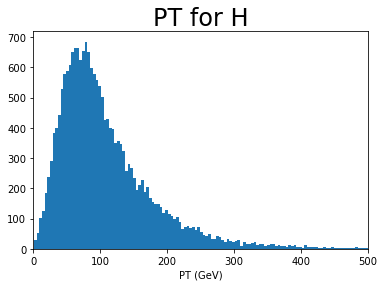

In [8]:
# Let's do some plots
h2_data = data[(data['Particle.PID'] == 35)]
print(h2_data['Particle.PT'].mean())
nbins = 300
hist = plt.hist(h2_data['Particle.PT'], bins=nbins)
plt.title(f'PT for H', fontsize=24)
plt.xlabel('PT (GeV)')
plt.xlim((0,500))


This is just the sum of the individual PTs, not the actual total PT_miss that will be measured -> need to combine the PT of all the inert scalars, start by doing this just for h2 then include the h3 

42.69793987372016


(0.0, 500.0)

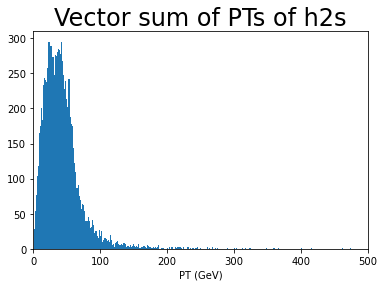

In [9]:

inert_data = data[(data['Particle.PID'] == 35)]
inert_data = inert_data.groupby(level=0).sum()
inert_data['PT_tot'] = np.sqrt(inert_data['Particle.Px']**2 + inert_data['Particle.Py']**2)
print(inert_data['PT_tot'].mean())
hist = plt.hist(inert_data['PT_tot'], bins=nbins)

plt.title(f'Vector sum of PTs of h2s', fontsize=24)
plt.xlabel('PT (GeV)')
plt.xlim((0,500))

-> The h2s like to go in opposite directions

In [10]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def getAngle(df):
    vs = df[['Particle.Px', 'Particle.Py', 'Particle.Pz']].to_numpy()
    angle = angle_between(vs[0,:2], vs[1,:2])
    return angle


Text(0.5, 0, 'Theta (radians)')

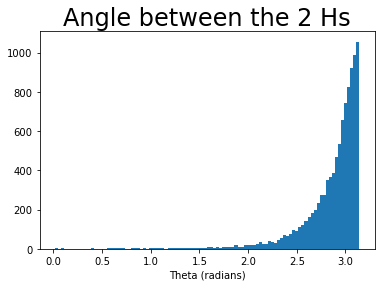

In [11]:
# Let's plot the angle between the h2s
inert_data = data[(data['Particle.PID'] == 35)]
g = inert_data.groupby('entry')
angles = g.apply(getAngle)

nbins = 100
n, bins, patches = plt.hist(angles, bins=nbins)

plt.title(f'Angle between the 2 Hs', fontsize=24)
plt.xlabel('Theta (radians)')


In [12]:
print(inert_data.loc[0])
print(inert_data.loc[0][['Particle.Px', 'Particle.Py', 'Particle.Pz']].to_numpy())

          Particle.PID  Particle.Px  Particle.Py  Particle.Pz  Particle.PT  \
subentry                                                                     
4                   35    40.846420   -10.176861   -32.462684    42.095112   
5                   35   -16.710442     3.911247  -266.681012    17.162073   

          Particle.E  Particle.Eta  
subentry                            
4          90.118240     -0.710001  
5         276.963485     -3.437532  
[[  40.84641969  -10.17686072  -32.46268383]
 [ -16.71044217    3.91124737 -266.68101212]]


(0.0, 500.0)

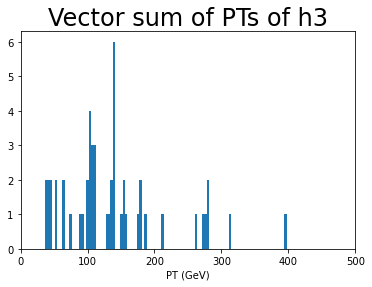

In [13]:
# Now for the h3

inert_data = data[(data['Particle.PID'] == 36)]


hist = plt.hist(inert_data['Particle.PT'], bins=nbins)

plt.title(f'Vector sum of PTs of h3', fontsize=24)
plt.xlabel('PT (GeV)')
plt.xlim((0,500))

(0.0, 500.0)

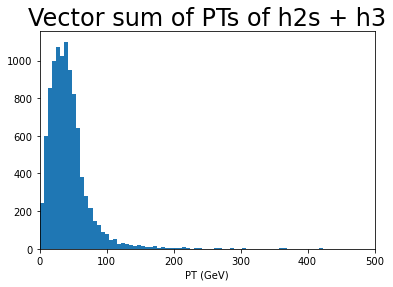

In [14]:

inert_data = data[(data['Particle.PID'] == 35) | (data['Particle.PID'] == 36)]
# This groups them into different events, then sums their Px, Py etc
# Can then find the abs of this to get the actual E_miss
inert_data = inert_data.groupby(level=0).sum()
inert_data['PT_tot'] = np.sqrt(inert_data['Particle.Px']**2 + inert_data['Particle.Py']**2)

hist = plt.hist(inert_data['PT_tot'], bins=nbins)

plt.title(f'Vector sum of PTs of h2s + h3', fontsize=24)
plt.xlabel('PT (GeV)')
plt.xlim((0,500))

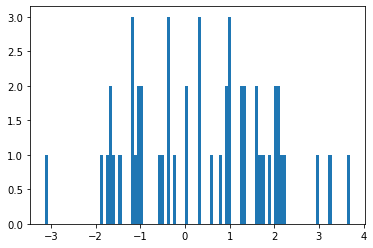

In [15]:
# Plot of the eta angle of the A
# Now for the h3

inert_data = data[(data['Particle.PID'] == 36)]

H_eta = inert_data['Particle.Eta']
nbins=100
hist = plt.hist(H_eta, bins=nbins)


164.7267754284974


Text(0.5, 0, 'PT (GeV)')

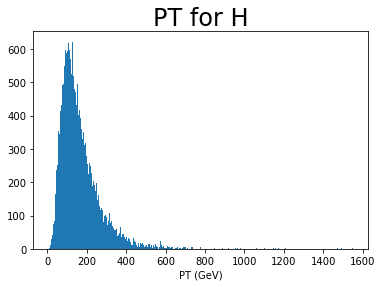

In [16]:
# plot the distribution of the H+- particles 
# Let's do some plots
Hch_data = data[(abs(data['Particle.PID']) == 37)]
print(Hch_data['Particle.PT'].mean())
nbins = 300
hist = plt.hist(Hch_data['Particle.PT'], bins=nbins)
plt.title(f'PT for H', fontsize=24)
plt.xlabel('PT (GeV)')
#plt.xlim((0,500))


In [92]:
# I can also plot the lifetime of the A particle
# Now for the h3

inert_data = data[(data['Particle.PID'] == 36)]

lifetimes = inert_data['Particle.LifeTime']
nbins = 100
hist = plt.hist(lifetimes, bins=nbins)
plt.xlim((0,0.02))

# So it doesn't live for very long!

KeyError: 'Particle.LifeTime'

24.478235397351234
14.690685631825556
2.5327279110666785


Text(1, 0, 'PT (GeV)')

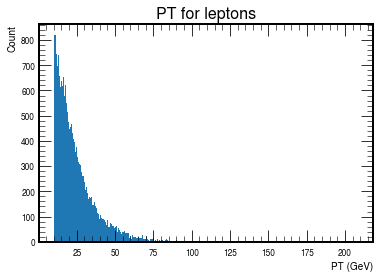

In [93]:
# Let's do some plots for the leptons

lepton_data = data[(abs(data['Particle.PID']) == 11) | (abs(data['Particle.PID']) == 13)]

print(lepton_data['Particle.PT'].mean())
print(lepton_data['Particle.PT'].std())
print(lepton_data['Particle.PT'].skew())
nbins = 300
n, bins, patches = plt.hist(lepton_data['Particle.PT'], bins=nbins)
plt.title(f'PT for leptons', fontsize=16)
plt.ylabel('Count')
plt.xlabel('PT (GeV)')
#plt.xlim((0,500))


50.0597523908517


Text(1, 0, 'E (GeV)')

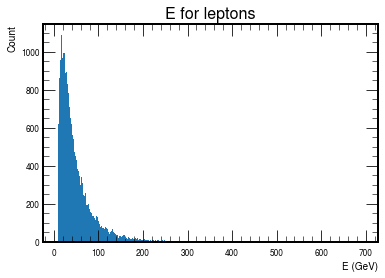

In [94]:
# Lepton energy
print(lepton_data['Particle.E'].mean())
nbins = 300
n, bins, patches = plt.hist(lepton_data['Particle.E'], bins=nbins)
plt.title(f'E for leptons', fontsize=16)
plt.ylabel('Count')
plt.xlabel('E (GeV)')
#plt.xlim((0,500))

Text(0.5, 1.0, 'Lepton PT')

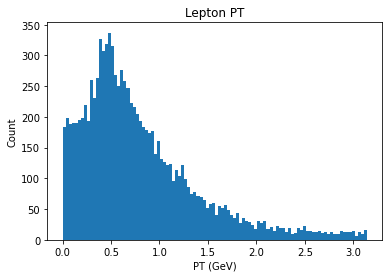

In [8]:
# Angle between the two leptons
lepton_data = data[(abs(data['Particle.PID']) == 11) | (abs(data['Particle.PID']) == 13)]

g = lepton_data.groupby('entry')
angles = g.apply(getAngle)

nbins = 100
n, bins, patches = plt.hist(angles, bins=nbins)
plt.xlabel('PT (GeV)')
plt.ylabel('Count')
plt.title('Lepton PT')

Text(0.5, 1.0, 'Jet PT')

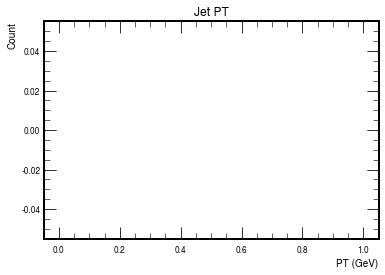

In [96]:
# Let's look at the jets now
# First get rid of the particles that are travelling
# down the beam pipe (e.g. a u with eta=999)
signal_data = data[(abs(data['Particle.Eta']) < 998)]
# Now pick out the quarks
quarks = [1,2,3,4,5]
signal_data = signal_data[abs(signal_data['Particle.PID']).isin(quarks)]

# Plot of PT
nbins = 50
n, bins, patches = plt.hist(signal_data['Particle.PT'], bins=nbins)
plt.xlabel('PT (GeV)')
plt.ylabel('Count')
plt.title('Jet PT')

Text(0.5, 1.0, 'Jet Eta')

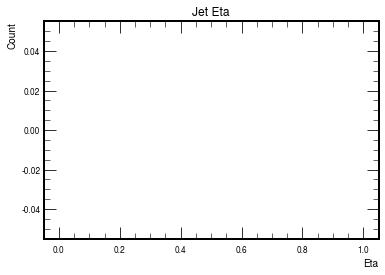

In [97]:
# Plot of jet eta
nbins = 50
n, bins, patches = plt.hist(signal_data['Particle.Eta'], bins=nbins)
plt.xlabel('Eta')
plt.ylabel('Count')
plt.title('Jet Eta')

Welcome to JupyROOT 6.26/04


Warning in <TClass::Init>: no dictionary for class TRootLHEFEvent is available
Warning in <TClass::Init>: no dictionary for class TRootWeight is available
Warning in <TClass::Init>: no dictionary for class TRootLHEFParticle is available
Warning in <TClass::Init>: no dictionary for class TSortableObject is available
Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


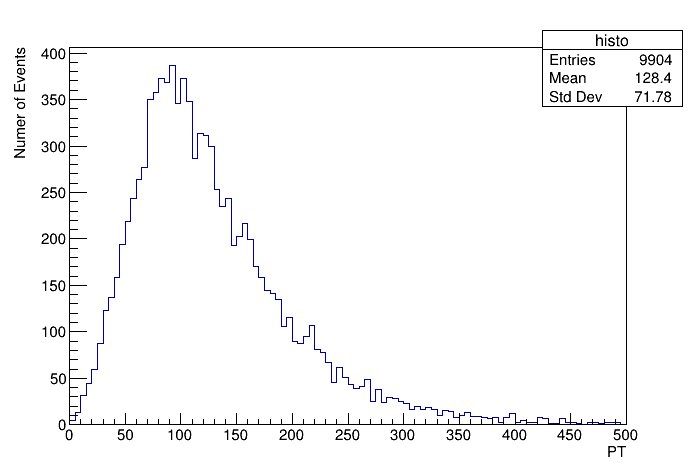

In [77]:
import ROOT

# ROOT.gSystem.Load("/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/libExRootAnalysis.so")
ROOT.gInterpreter.Declare('#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeBranch.h"')

# p p > h2 h2 l+ l-
# This reads in the file
inFile = ROOT.TFile.Open("/vols/cms/emc21/FCC/MadGraph_files/distributions/h2h2lPlMj_l_e_mu/BP1/h2h2lPlMj_l_e_mu_BP1/Events/run_01/unweighted_events.root")
# This get's the tree from the file
# The argument LHEF is the name of the tree -> Can be found by the root gui file thing
tree = inFile.Get("LHEF")

histo = ROOT.TH1F("histo", ";PT; Numer of Events", 100, 0, 500)
#tree.Draw("Particle.E>>histo", "Particle.PID == 35 && Particle.Eta > -1 && Particle.Eta < 1")
tree.Draw("Particle.PT>>histo", "Particle.PID == 36")
myc = ROOT.TCanvas("myc","myc",1)
myc.cd()
histo.Draw()
myc.Draw()
# Why are there so many Z bosons in the final state as well? Something to ask AM.